In [55]:
from fastapi import FastAPI, File, UploadFile
from enum import Enum
import uvicorn
import numpy as np
from io import BytesIO
from PIL import Image
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools


def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)


In [56]:
# content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
content_path = "mango.jpeg"
# style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
style_path = "Palm-Trees-Sunset-Scenery-Digital-Art-4K-Wallpaper.jpg"

In [57]:
def load_img(path_to_img):
  max_dim = 512
  # max_dim = 1024
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [58]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

(1, 512, 512, 3) (1, 288, 512, 3)


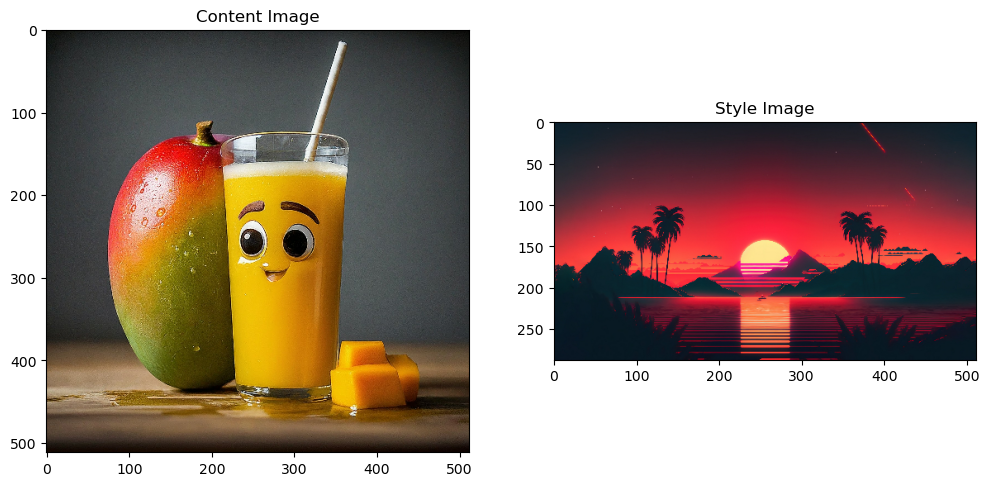

In [59]:
content_image = load_img(content_path)
style_image = load_img(style_path)
print(content_image.shape, style_image.shape)
plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [60]:
# vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

# Choose intermediate layers from the network to represent the style and content of the image:
# 

# In[ ]:


content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [61]:

def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
#   vgg = tf.keras.models.load_model("vgg19_imagenet.h5")
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [62]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)


In [63]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*1.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}


extractor = StyleContentModel(style_layers, content_layers)
# When called on an image, this model returns the gram matrix (style) of the `style_layers` and content of the `content_layers`:


In [64]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)



In [65]:
style_weight=1e-2
content_weight=1e4


# In[ ]:


def style_content_loss(outputs, style_targets, content_targets):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss


In [66]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

@tf.function()
def train_step(image,style_targets, content_targets):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs, style_targets, content_targets)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))


In [67]:
def generate_image(image, epochs, style_targets, content_targets):
  epochs = int(epochs)
  for n in tqdm(range(epochs)):
    train_step(image, style_targets, content_targets)
  return image


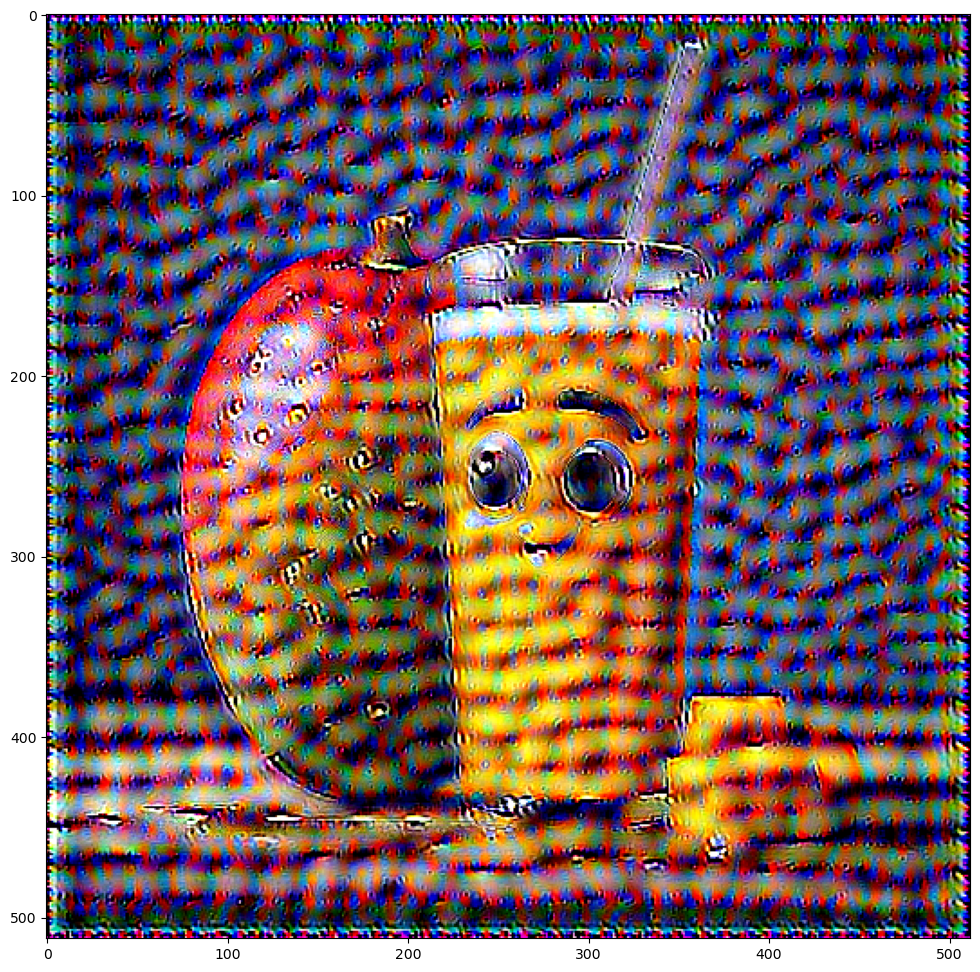

In [68]:

# print(type(sty_img), type(cont_img))
# content_image , style_image = cont_img, sty_img
content_image = tf.convert_to_tensor(content_image)
style_image = tf.convert_to_tensor(style_image)
# content_image = tf.expand_dims(content_image, 0)
# style_image = tf.expand_dims(style_image, 0)
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image)

extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

final_image = generate_image(image, 50, style_targets, content_targets)
imshow(final_image)